In [46]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')

In [90]:
train.head()

test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Ln_Age,Ln_CreditScore,Balance_Group,Balance_NumOfProducts
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,3.178054,6.375025,0,0.00
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,3.850148,6.527958,0,0.00
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,3.555348,6.487684,0,0.00
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,3.610918,6.525030,0,0.00
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,3.663562,6.624065,2,121263.62


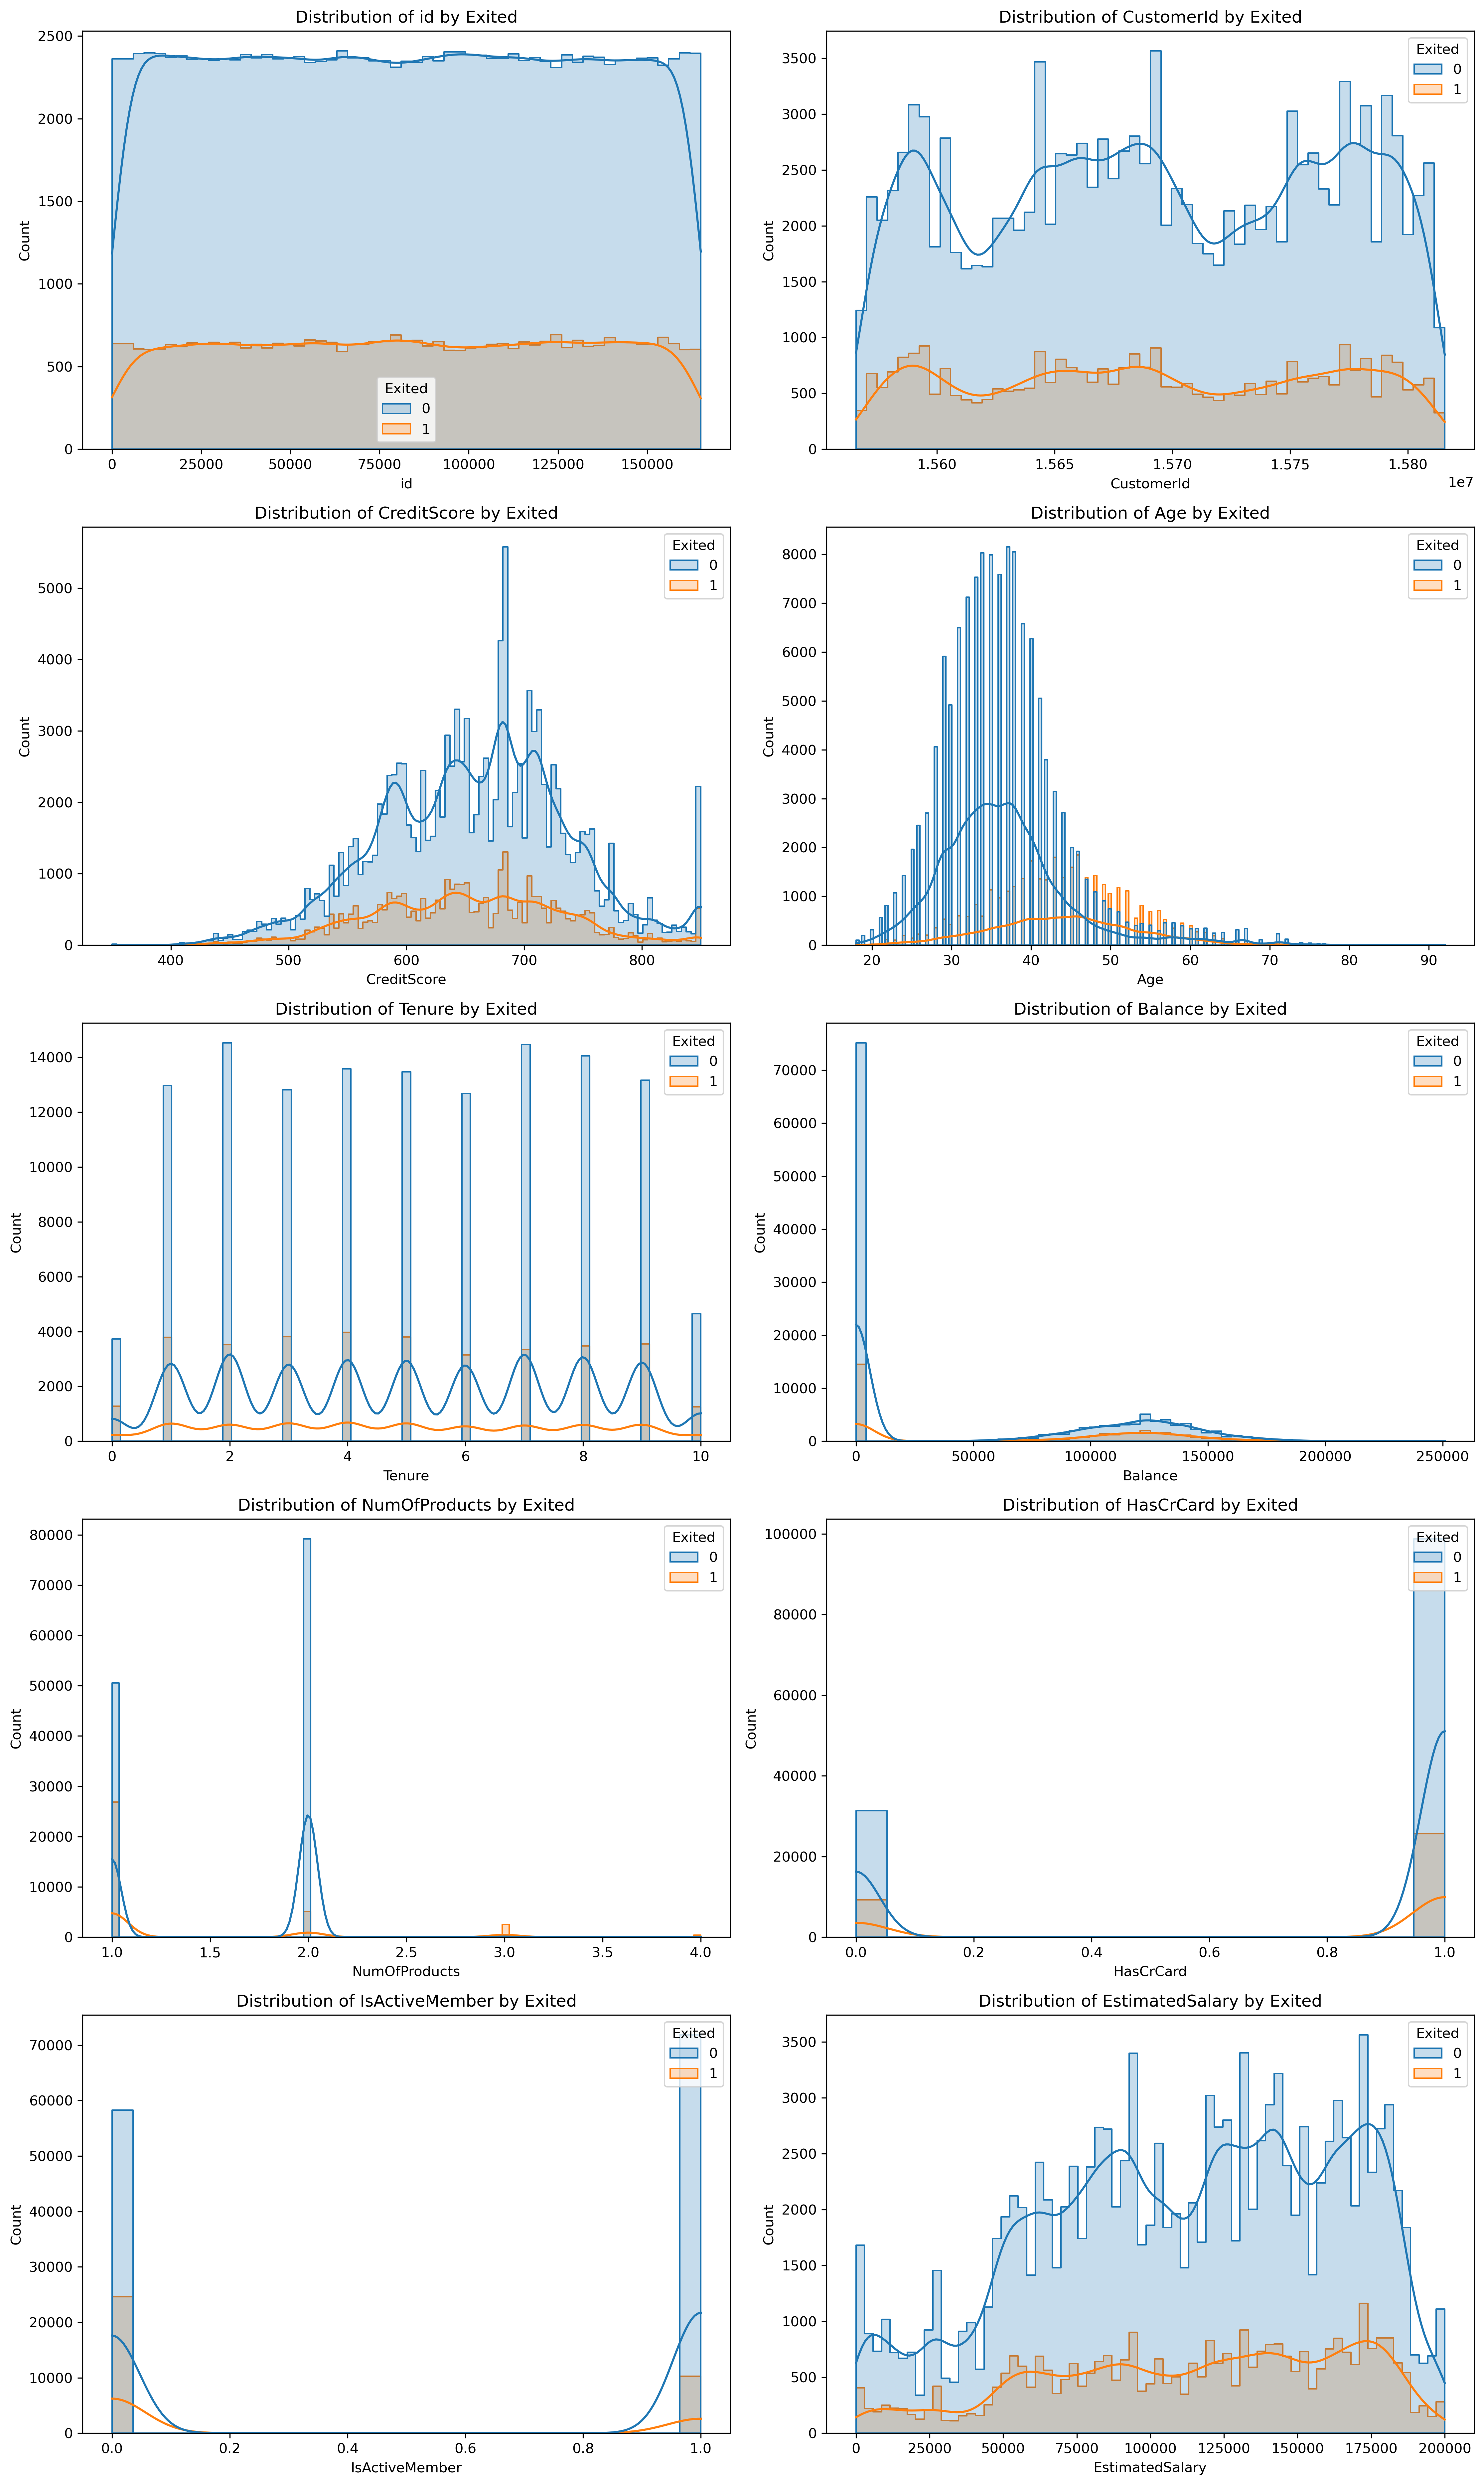

In [56]:
# Drawing the distribution of the data on multiple subplots grouped by 'Exited' column
# We will create a subplot for numerical columns only
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns[:-1]

# Number of rows and columns for the subplot
n_rows = len(numerical_columns) // 2 + len(numerical_columns) % 2
n_cols = 2

# Creating subplots
plt.figure(figsize=(15, 5 * n_rows), dpi=300)
for i, col in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=train, x=col, hue="Exited", kde=True, element="step")
    plt.title(f'Distribution of {col} by Exited')
plt.tight_layout()
plt.show()


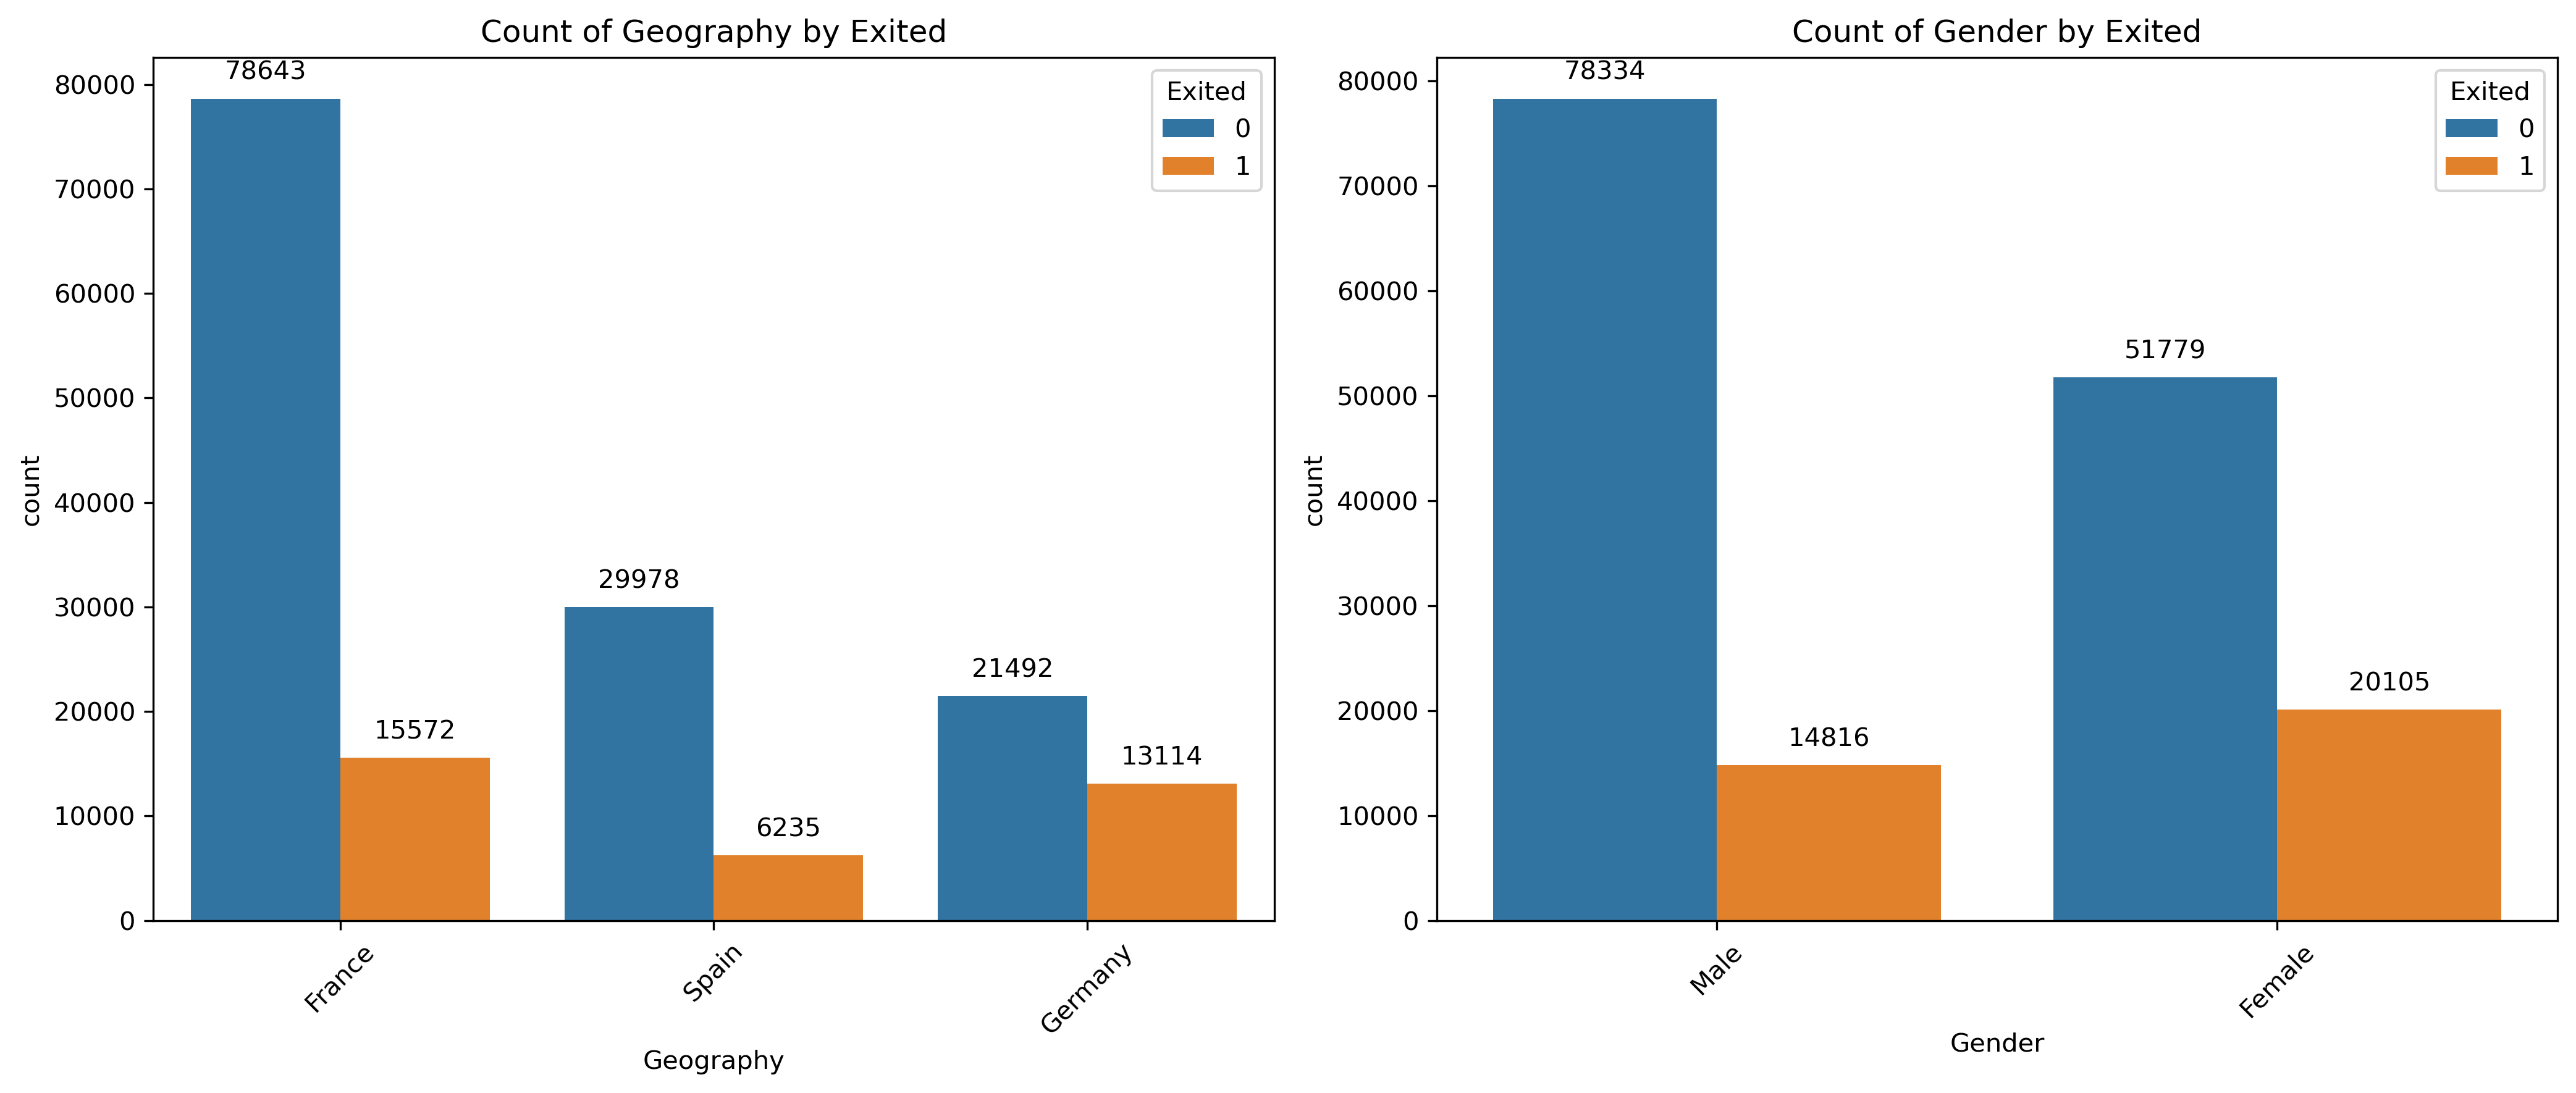

In [17]:
# Selecting specific categorical columns
categorical_columns = ['Geography', 'Gender']

# Setting up subplots
n_cols = 2
fig, axes = plt.subplots(1, n_cols, figsize=(14, 6), dpi=300)

# Iterating over each categorical column
for i, col in enumerate(categorical_columns):
    # Plotting
    ax = sns.countplot(data=train, x=col, hue="Exited", ax=axes[i])
    ax.set_title(f'Count of {col} by Exited')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Adding value labels on the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [79]:
def engineer_features(data):
    # Apply natural log to Age and CreditScore to reduce skewness
    data['Ln_Age'] = np.log(data['Age'] + 1)  # Adding 1 to avoid log(0)
    data['Ln_CreditScore'] = np.log(data['CreditScore'] + 1)

    # Create groups for Balance
    data['Balance_Group'] = pd.cut(data['Balance'], bins=[-np.inf, 50000, 100000, np.inf], labels=[0, 1, 2], right=False)
    

    # Create interaction terms
    data['Balance_NumOfProducts'] = data['Balance'] * data['NumOfProducts']

    # One-Hot Encoding for Categorical Variables
    categorical_cols = ['Geography', 'Gender']
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

    # Adding interaction terms with Log_Age
    data['Ln_Age_Balance'] = data['Ln_Age'] * data['Balance']
    data['Ln_Age_NumOfProducts'] = data['Ln_Age'] * data['NumOfProducts']

    return data

print(f"Shape of TRAIN before engineering:", train.shape)
print(f"Shape of TEST  before engineering:", test.shape)

train_eng = engineer_features(train)
test_eng = engineer_features(test)

print(f"Shape of TRAIN set AFTER engineering:", train_eng.shape)
print(f"Shape of TEST  set AFTER engineering:", test_eng.shape)


Shape of TRAIN before engineering: (165034, 14)
Shape of TEST  before engineering: (110023, 13)
Shape of TRAIN set AFTER engineering: (165034, 21)
Shape of TEST  set AFTER engineering: (110023, 20)


In [69]:
def type_correction(data):
    data['Balance_Group'] = data['Balance_Group'].astype('category')
    data['IsActiveMember'] = data['IsActiveMember'].astype('category')
    data['HasCrCard'] = data['HasCrCard'].astype('category')
    data['Geography_Germany'] = data['Geography_Germany'].astype('category')
    data['Geography_Spain'] = data['Geography_Spain'].astype('category')
    data['Gender_Male'] = data['Gender_Male'].astype('category')

    return data

train_eng = type_correction(train_eng)
test_eng = type_correction(test_eng)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

random_state=42 

In [92]:
# Splitting the data
X = train_eng.drop(['Exited', 'id', 'Surname', 'Age', ], axis=1)  # Replace 'Exited' with your target variable name
y = train['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_eng.drop(['id', 'Surname', 'Age', ], axis=1)  # Replace 'Exited' with your target variable name

# Convert categorical columns to category type
categorical_cols = ['HasCrCard', 'IsActiveMember', 'Balance_Group', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')  
    X_val[col] = X_val[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Initialize models
lgbm = LGBMClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgboost = XGBClassifier(enable_categorical=True, tree_method='hist', random_state=42)

In [83]:
xgboost = XGBClassifier(enable_categorical=True, tree_method='hist', random_state=42)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [84]:
# Train models
lgbm.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

# Ensemble Model
ensemble = VotingClassifier(estimators=[('lgbm', lgbm), ('rf', rf), ('xgboost', xgboost)], voting='soft')
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                     

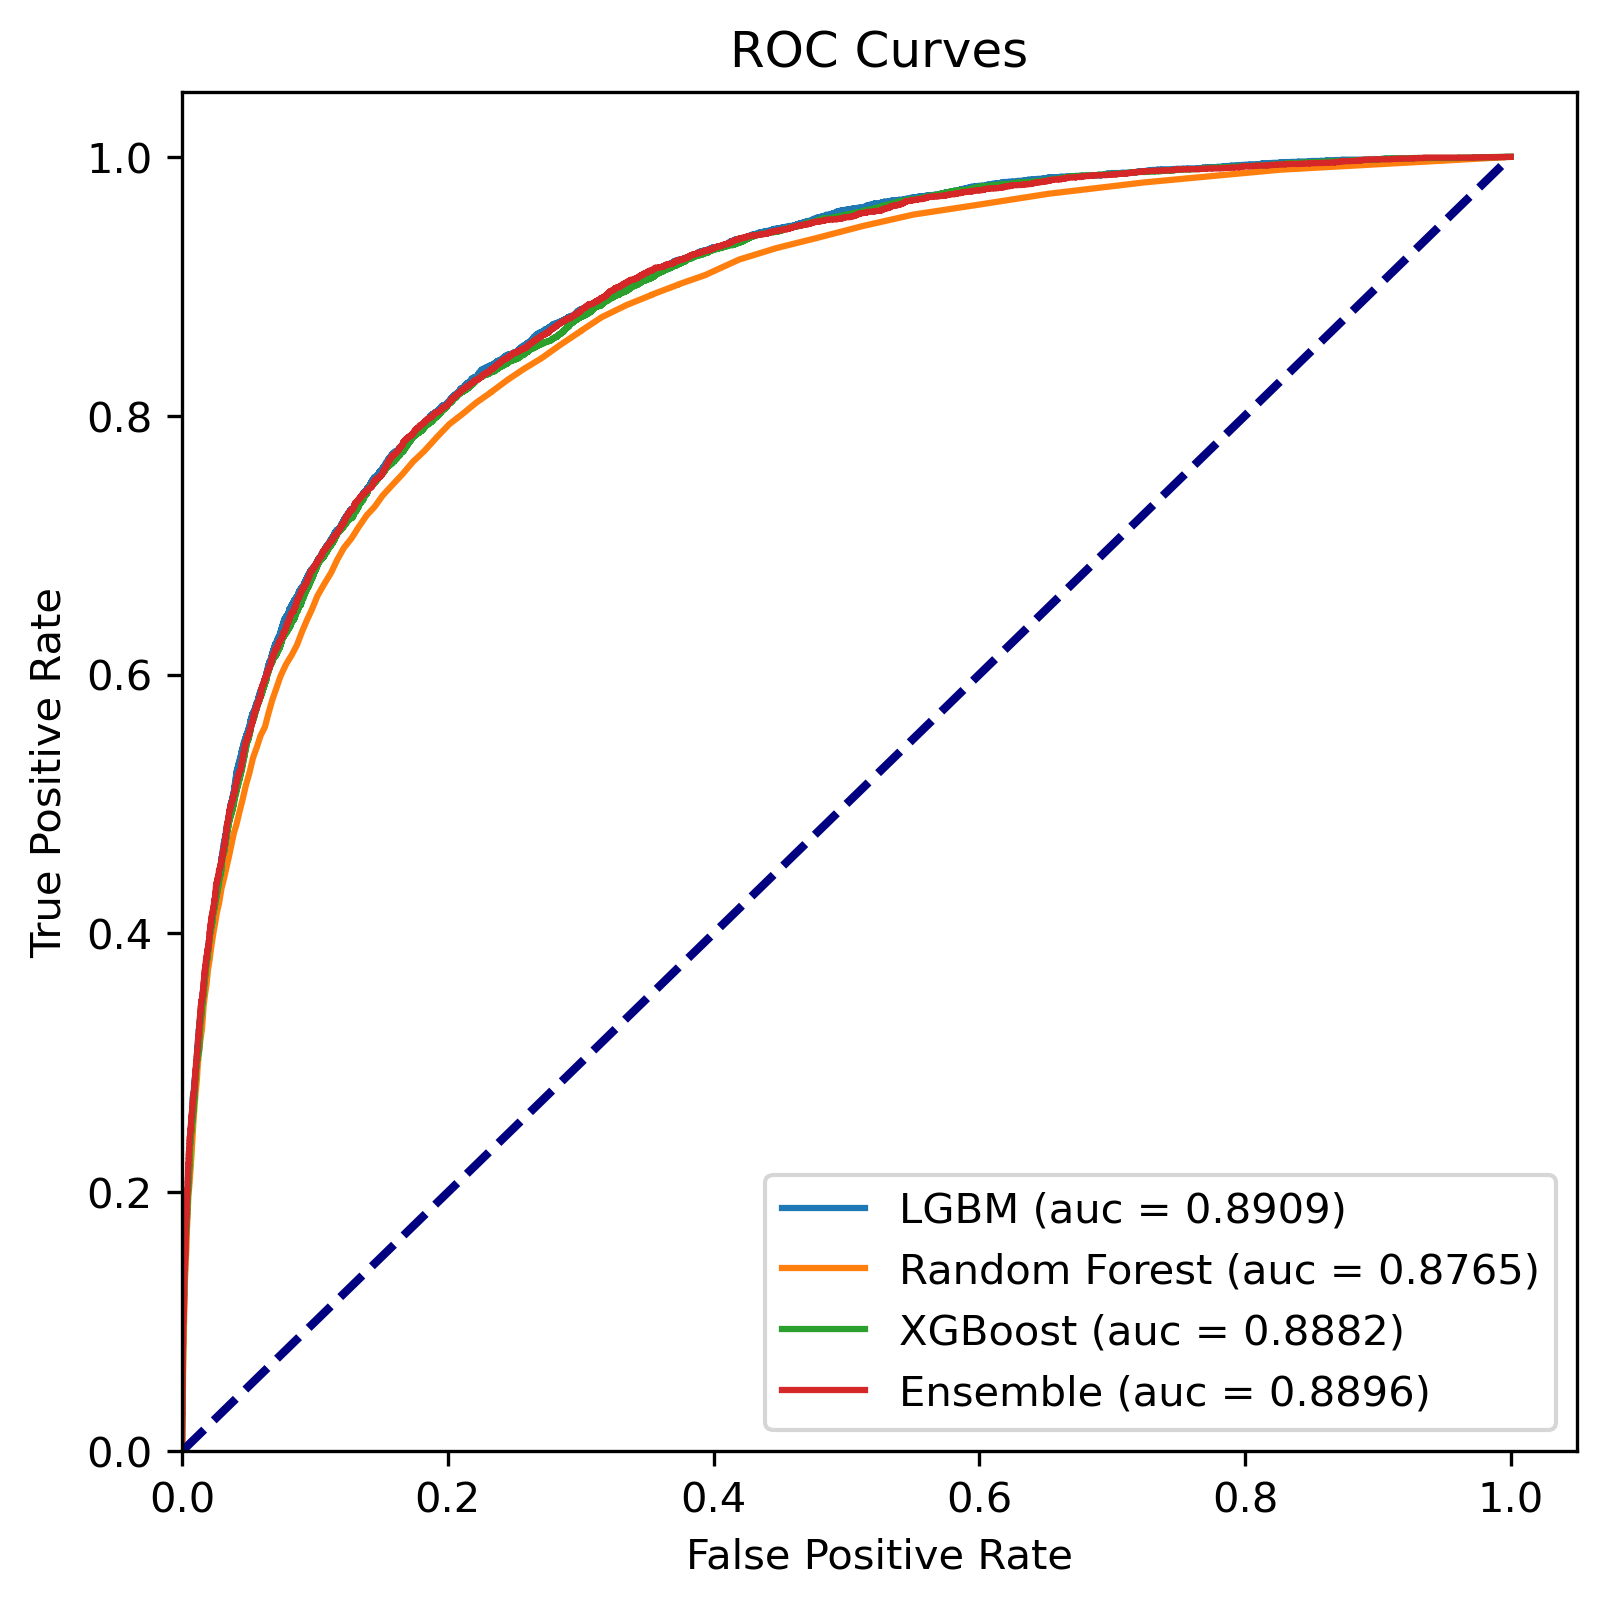

In [87]:
# Function to plot ROC curve
def plot_roc_curve(model, X, y, model_name):
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    auc = roc_auc_score(y, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (auc = {auc:.4f})")

# Plotting ROC Curves
plt.figure(figsize=(6, 6), dpi=300)

plot_roc_curve(lgbm, X_val, y_val, 'LGBM')
plot_roc_curve(rf, X_val, y_val, 'Random Forest')
plot_roc_curve(xgboost, X_val, y_val, 'XGBoost')
plot_roc_curve(ensemble, X_val, y_val, 'Ensemble')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [93]:
pred_proba=ensemble.predict_proba(X_test)

In [94]:
pred_proba[:,1]

array([[0.98072847, 0.01927152],
       [0.18687394, 0.81312606],
       [0.98432708, 0.01567292],
       ...,
       [0.98114361, 0.0188564 ],
       [0.82315872, 0.17684128],
       [0.8099032 , 0.1900968 ]])

In [95]:
submit = pd.DataFrame({'id':submission['id'], 'Exited':pred_proba[:,1]})

submit.to_csv('./predictions_ensemble.csv',index=False)
print('Submitted Successfully')

Submitted Successfully
